Used python3 to have l1_ratio option for logistic regression from sklearn

In [2]:
import numpy as np, pandas as pd, pickle, matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [3]:
surv_df_filter2 = pd.read_csv('PD_outcomes_filter2yrs.csv')
surv_df_filter3 = pd.read_csv('PD_outcomes_filter3yrs.csv')

In [4]:
with open('../finalized_outcome_survival_models/final_all_covariate_sets.pkl', 'rb') as f:
    all_covariate_sets = pickle.load(f, encoding='latin1')
baseline_df = pd.read_csv('../finalized_outcome_survival_models/final_survival_baseline_data.csv')

In [5]:
with open('test_patnos_filter2.pkl', 'rb') as f:
    filter2_test_patnos = pickle.load(f, encoding='latin1')
with open('test_patnos_filter3.pkl', 'rb') as f:
    filter3_test_patnos = pickle.load(f, encoding='latin1')

In [6]:
np.random.seed(2047)
motor_surv_df_filter2 = surv_df_filter2[['PATNO','Motor_T','Motor_E']]
motor_bl_cov_set = list(all_covariate_sets['baseline']['Motor'])
motor_bl_df = baseline_df[['PATNO'] + motor_bl_cov_set]
motor_bl_df = motor_surv_df_filter2.merge(motor_bl_df, on=['PATNO'], validate='one_to_one').dropna()
assert set(filter2_test_patnos['Motor'].tolist()).issubset(set(motor_bl_df.PATNO.values.tolist()))
test_motor_bl_df = motor_bl_df.loc[motor_bl_df['PATNO'].isin(filter2_test_patnos['Motor'])]
train_valid_motor_bl_df = motor_bl_df.loc[~motor_bl_df['PATNO'].isin(filter2_test_patnos['Motor'])]
test_X = test_motor_bl_df[motor_bl_cov_set].values
test_Y = test_motor_bl_df['Motor_E'].values
test_patnos_arr = test_motor_bl_df['PATNO'].values
train_valid_patnos = train_valid_motor_bl_df.PATNO.values
np.random.shuffle(train_valid_patnos)
train_X_folds = []
train_Y_folds = []
valid_X_folds = []
valid_Y_folds = []
for fold_idx in range(4):
    valid_patnos \
        = train_valid_patnos[int(fold_idx/4.*len(train_valid_patnos)):int((fold_idx+1)/4.*len(train_valid_patnos))]
    train_patnos = set(train_valid_patnos.tolist()).difference(set(valid_patnos.tolist()))
    train_motor_bl_df = train_valid_motor_bl_df.loc[train_valid_motor_bl_df['PATNO'].isin(train_patnos)]
    valid_motor_bl_df = train_valid_motor_bl_df.loc[train_valid_motor_bl_df['PATNO'].isin(valid_patnos)]
    train_X_folds.append(train_motor_bl_df[motor_bl_cov_set].values)
    train_Y_folds.append(train_motor_bl_df['Motor_E'].values)
    valid_X_folds.append(valid_motor_bl_df[motor_bl_cov_set].values)
    valid_Y_folds.append(valid_motor_bl_df['Motor_E'].values)

/afs/csail.mit.edu/u/c/cji/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/afs/csail.mit.edu/u/c/cji/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/afs/csail.mit.edu/u/c/cji/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/afs/csail.mit.edu/u/c/cji/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/afs/csa

/afs/csail.mit.edu/u/c/cji/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/afs/csail.mit.edu/u/c/cji/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/afs/csail.mit.edu/u/c/cji/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/afs/csail.mit.edu/u/c/cji/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/afs/csa

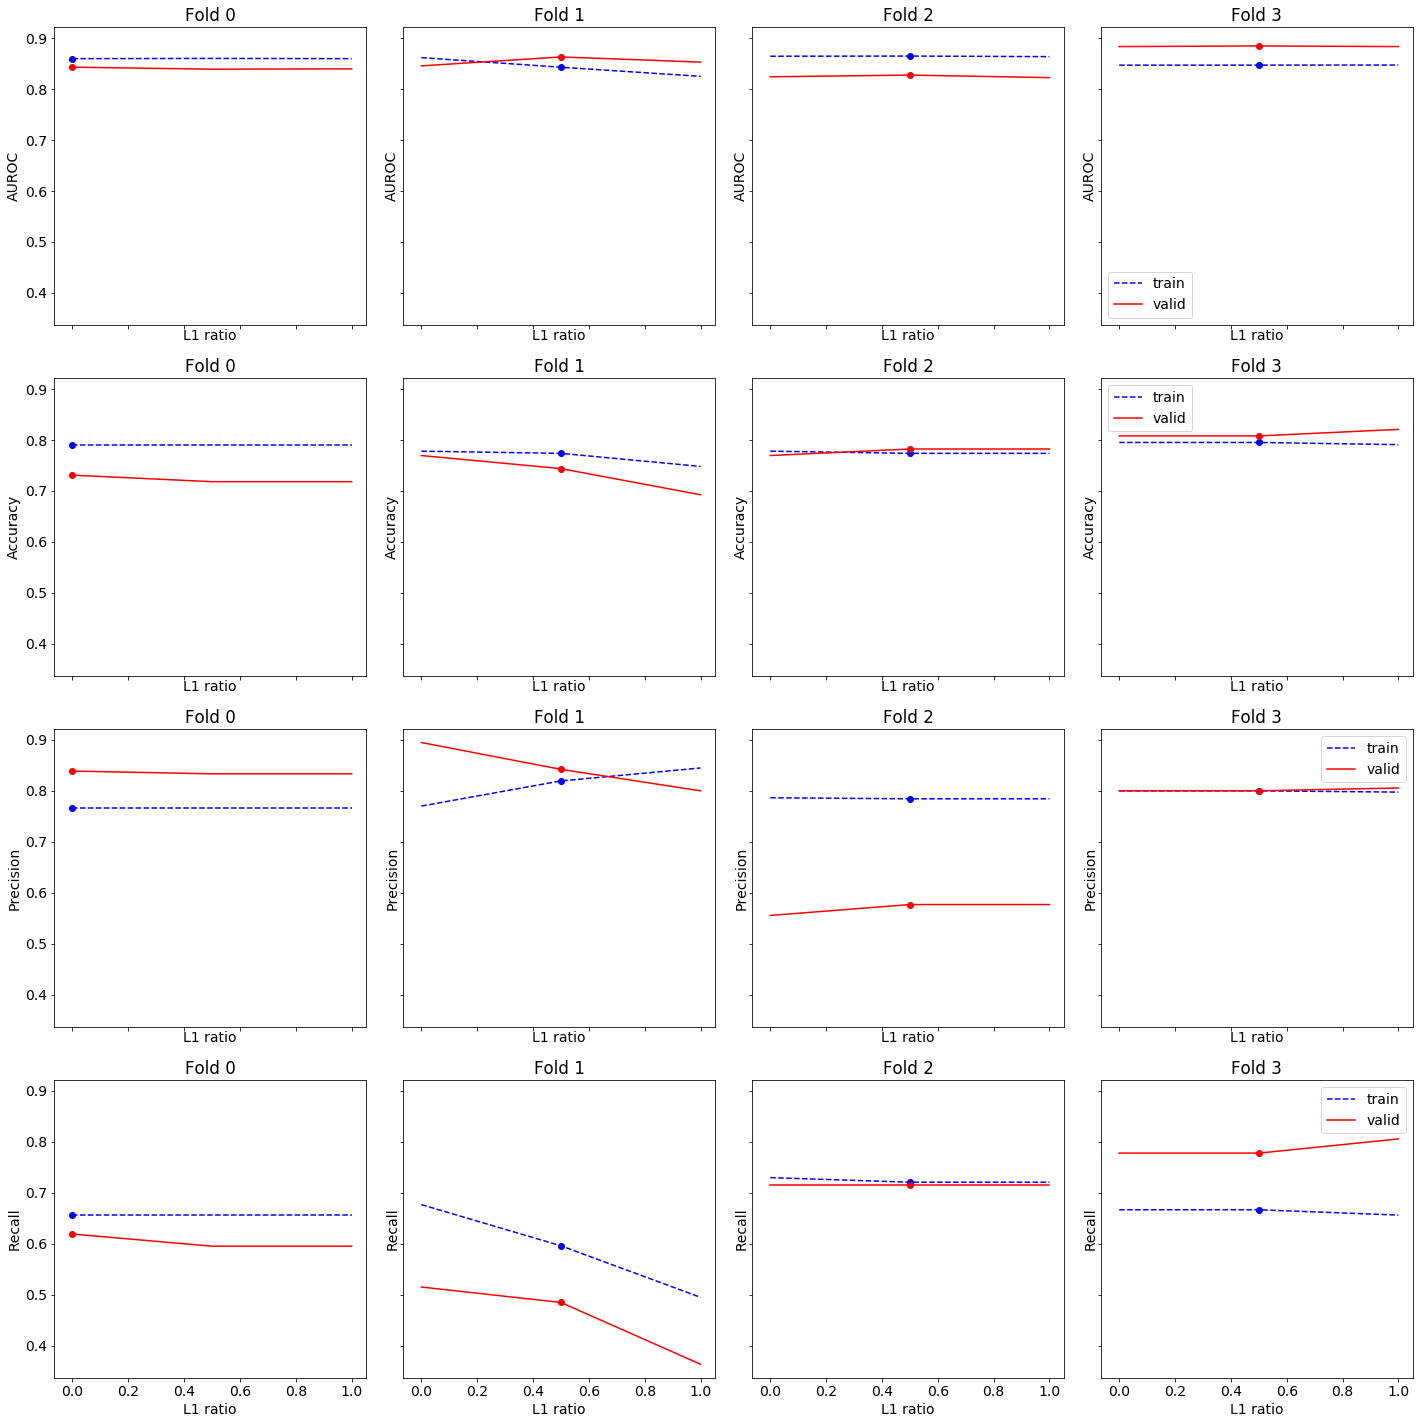

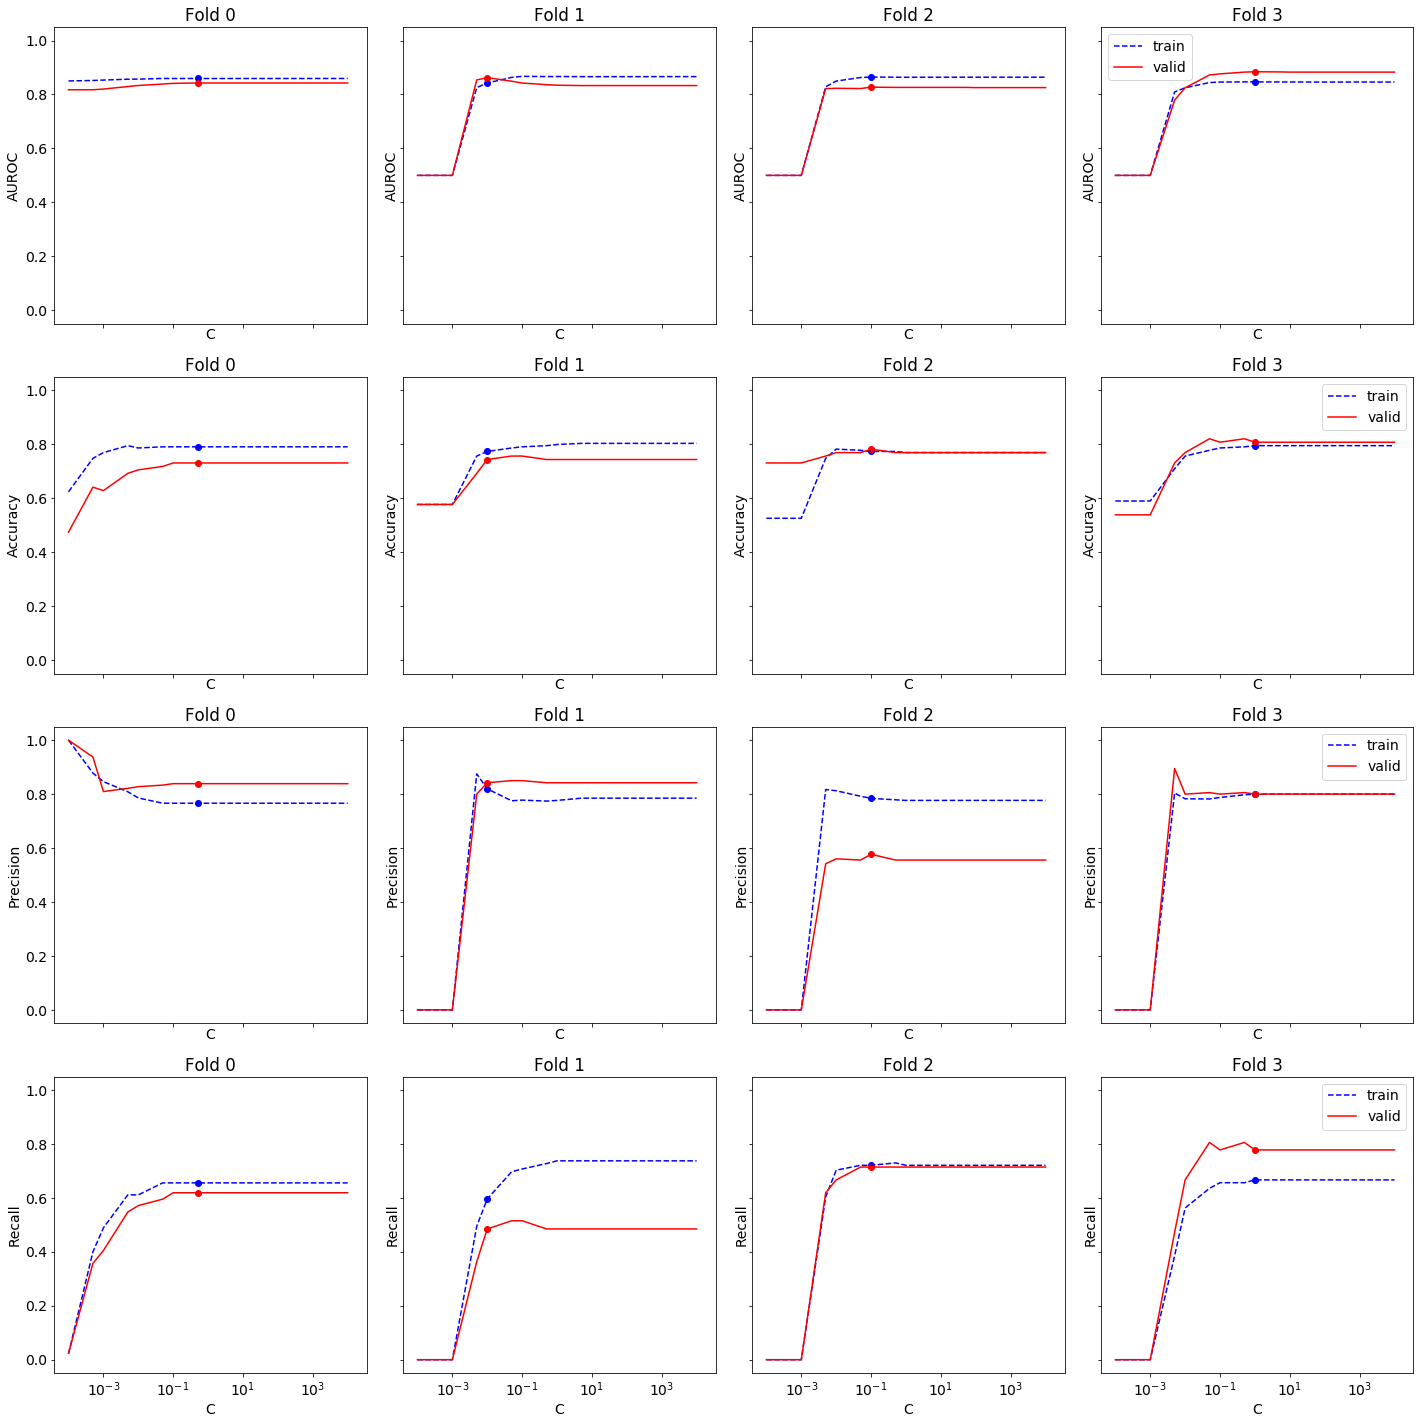

In [36]:
plt.rcParams.update({'font.size': 16})
fold_test_metrics_dict = {'auroc': [], 'acc': [], 'prec': [], 'rec': []}
fold_test_coefs = pd.DataFrame({'Feature': motor_bl_cov_set})
fold_vary_l1_ratio_fig, fold_vary_l1_ratio_ax = plt.subplots(nrows=4, ncols=4, figsize=(20,20), sharex=True, \
                                                             sharey=True)
fold_vary_C_fig, fold_vary_C_ax = plt.subplots(nrows=4, ncols=4, figsize=(20,20), sharex=True, sharey=True)
metric_list = ['auroc', 'acc', 'prec', 'rec']
metric_human_readable_list = ['AUROC', 'Accuracy', 'Precision', 'Recall']
for fold_idx in range(4):
    train_X = train_X_folds[fold_idx]
    train_Y = train_Y_folds[fold_idx]
    valid_X = valid_X_folds[fold_idx]
    valid_Y = valid_Y_folds[fold_idx]
    l1_ratios = [0., 0.5, 1.0]
    Cs = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1., 5., 10., 50., 100., 500., 1000., 5000., 1e4]
    best_valid_auroc = 0.
    best_valid_acc = 0.
    best_valid_prec = 0.
    best_valid_rec = 0.
    train_vary_l1_ratio_metrics_dict = dict()
    train_vary_C_metrics_dict = dict()
    valid_vary_l1_ratio_metrics_dict = dict()
    valid_vary_C_metrics_dict = dict()
    for l1_ratio in l1_ratios:
        train_vary_C_metrics_dict[l1_ratio] = {'auroc': [], 'acc': [], 'prec': [], 'rec': []}
        valid_vary_C_metrics_dict[l1_ratio] = {'auroc': [], 'acc': [], 'prec': [], 'rec': []}
    for C in Cs:
        train_vary_l1_ratio_metrics_dict[C] = {'auroc': [], 'acc': [], 'prec': [], 'rec': []}
        valid_vary_l1_ratio_metrics_dict[C] = {'auroc': [], 'acc': [], 'prec': [], 'rec': []}
        for l1_ratio in l1_ratios:
            log_reg = LogisticRegression(penalty='elasticnet', l1_ratio=l1_ratio, C=C, max_iter=1000, solver='saga')
            log_reg.fit(train_X, train_Y)
            train_pred = log_reg.predict(train_X)
            train_prob = log_reg.predict_proba(train_X)[:,1]
            valid_pred = log_reg.predict(valid_X)
            valid_prob = log_reg.predict_proba(valid_X)[:,1]
            valid_auroc = roc_auc_score(valid_Y, valid_prob)
            valid_acc = accuracy_score(valid_Y, valid_pred)
            valid_prec = precision_score(valid_Y, valid_pred)
            valid_rec = recall_score(valid_Y, valid_pred)
            train_auroc = roc_auc_score(train_Y, train_prob)
            train_acc = accuracy_score(train_Y, train_pred)
            train_prec = precision_score(train_Y, train_pred)
            train_rec = recall_score(train_Y, train_pred)
            train_vary_l1_ratio_metrics_dict[C]['auroc'].append(train_auroc)
            train_vary_l1_ratio_metrics_dict[C]['acc'].append(train_acc)
            train_vary_l1_ratio_metrics_dict[C]['prec'].append(train_prec)
            train_vary_l1_ratio_metrics_dict[C]['rec'].append(train_rec)
            train_vary_C_metrics_dict[l1_ratio]['auroc'].append(train_auroc)
            train_vary_C_metrics_dict[l1_ratio]['acc'].append(train_acc)
            train_vary_C_metrics_dict[l1_ratio]['prec'].append(train_prec)
            train_vary_C_metrics_dict[l1_ratio]['rec'].append(train_rec)
            valid_vary_l1_ratio_metrics_dict[C]['auroc'].append(valid_auroc)
            valid_vary_l1_ratio_metrics_dict[C]['acc'].append(valid_acc)
            valid_vary_l1_ratio_metrics_dict[C]['prec'].append(valid_prec)
            valid_vary_l1_ratio_metrics_dict[C]['rec'].append(valid_rec)
            valid_vary_C_metrics_dict[l1_ratio]['auroc'].append(valid_auroc)
            valid_vary_C_metrics_dict[l1_ratio]['acc'].append(valid_acc)
            valid_vary_C_metrics_dict[l1_ratio]['prec'].append(valid_prec)
            valid_vary_C_metrics_dict[l1_ratio]['rec'].append(valid_rec)
            if valid_auroc > best_valid_auroc or (valid_auroc == best_valid_auroc and valid_acc > best_valid_acc) \
                or (valid_auroc == best_valid_auroc and valid_acc == best_valid_acc and valid_prec > best_valid_prec) \
                or (valid_auroc == best_valid_auroc and valid_acc == best_valid_acc and valid_prec == best_valid_prec \
                    and valid_rec > best_valid_rec):
                best_valid_auroc = valid_auroc
                best_valid_acc = valid_acc
                best_valid_prec = valid_prec
                best_valid_rec = valid_rec
                best_train_metrics_list = [train_auroc, train_acc, train_prec, train_rec]
                best_l1_ratio = l1_ratio
                best_C = C
                best_test_pred = log_reg.predict(test_X)
                best_test_prob = log_reg.predict_proba(test_X)[:,1]
                best_coefs = log_reg.coef_.flatten()
    best_valid_metrics_list = [best_valid_auroc, best_valid_acc, best_valid_prec, best_valid_rec]
    for metric_idx in range(len(metric_list)):
        metric = metric_list[metric_idx]
        fold_vary_l1_ratio_ax[metric_idx, fold_idx].plot(l1_ratios, train_vary_l1_ratio_metrics_dict[best_C][metric], \
                                                         c='b', linestyle='--', label='train')
        fold_vary_l1_ratio_ax[metric_idx, fold_idx].scatter(best_l1_ratio, best_train_metrics_list[metric_idx], \
                                                            c='b')
        fold_vary_l1_ratio_ax[metric_idx, fold_idx].plot(l1_ratios, valid_vary_l1_ratio_metrics_dict[best_C][metric], \
                                                         c='r', label='valid')
        fold_vary_l1_ratio_ax[metric_idx, fold_idx].scatter(best_l1_ratio, best_valid_metrics_list[metric_idx], \
                                                            c='r')
        fold_vary_l1_ratio_ax[metric_idx, fold_idx].set_xlabel('L1 ratio')
        fold_vary_l1_ratio_ax[metric_idx, fold_idx].set_ylabel(metric_human_readable_list[metric_idx])
        fold_vary_l1_ratio_ax[metric_idx, fold_idx].set_title('Fold ' + str(fold_idx))
        fold_vary_C_ax[metric_idx, fold_idx].plot(Cs, train_vary_C_metrics_dict[best_l1_ratio][metric], c='b', \
                                                  linestyle='--', label='train')
        fold_vary_C_ax[metric_idx, fold_idx].scatter(best_C, best_train_metrics_list[metric_idx], c='b')
        fold_vary_C_ax[metric_idx, fold_idx].plot(Cs, valid_vary_C_metrics_dict[best_l1_ratio][metric], c='r', \
                                                  label='valid')
        fold_vary_C_ax[metric_idx, fold_idx].scatter(best_C, best_valid_metrics_list[metric_idx], c='r')
        fold_vary_C_ax[metric_idx, fold_idx].set_xlabel('C')
        fold_vary_C_ax[metric_idx, fold_idx].set_ylabel(metric_human_readable_list[metric_idx])
        fold_vary_C_ax[metric_idx, fold_idx].set_title('Fold ' + str(fold_idx))
        fold_vary_C_ax[metric_idx, fold_idx].set_xscale('log')
    fold_test_coefs['coef_fold' + str(fold_idx)] = best_coefs
    fold_test_metrics_dict['auroc'].append(roc_auc_score(test_Y, best_test_prob))
    fold_test_metrics_dict['acc'].append(accuracy_score(test_Y, best_test_pred))
    fold_test_metrics_dict['prec'].append(precision_score(test_Y, best_test_pred))
    fold_test_metrics_dict['rec'].append(recall_score(test_Y, best_test_pred))
for metric_idx in range(len(metric_list)):
    fold_vary_l1_ratio_ax[metric_idx, 3].legend()
    fold_vary_C_ax[metric_idx, 3].legend()
fold_vary_l1_ratio_fig.tight_layout()
fold_vary_l1_ratio_fig.show()
fold_vary_C_fig.tight_layout()
fold_vary_C_fig.show()

In [37]:
print(fold_test_metrics_dict)

{'prec': [0.6428571428571429, 0.6923076923076923, 0.625, 0.625], 'acc': [0.7142857142857143, 0.7321428571428571, 0.7142857142857143, 0.7142857142857143], 'auroc': [0.6305555555555556, 0.625, 0.6777777777777778, 0.6541666666666667], 'rec': [0.45, 0.45, 0.5, 0.5]}


In [38]:
print(best_l1_ratio)
print(best_C)

0.5
1.0


/afs/csail.mit.edu/u/c/cji/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/afs/csail.mit.edu/u/c/cji/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/afs/csail.mit.edu/u/c/cji/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/afs/csail.mit.edu/u/c/cji/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/afs/csa

/afs/csail.mit.edu/u/c/cji/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/afs/csail.mit.edu/u/c/cji/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/afs/csail.mit.edu/u/c/cji/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/afs/csail.mit.edu/u/c/cji/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/afs/csa

/afs/csail.mit.edu/u/c/cji/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/afs/csail.mit.edu/u/c/cji/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/afs/csail.mit.edu/u/c/cji/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/afs/csail.mit.edu/u/c/cji/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/afs/csa

/afs/csail.mit.edu/u/c/cji/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/afs/csail.mit.edu/u/c/cji/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/afs/csail.mit.edu/u/c/cji/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/afs/csail.mit.edu/u/c/cji/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/afs/csa

/afs/csail.mit.edu/u/c/cji/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/afs/csail.mit.edu/u/c/cji/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/afs/csail.mit.edu/u/c/cji/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/afs/csail.mit.edu/u/c/cji/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/afs/csa

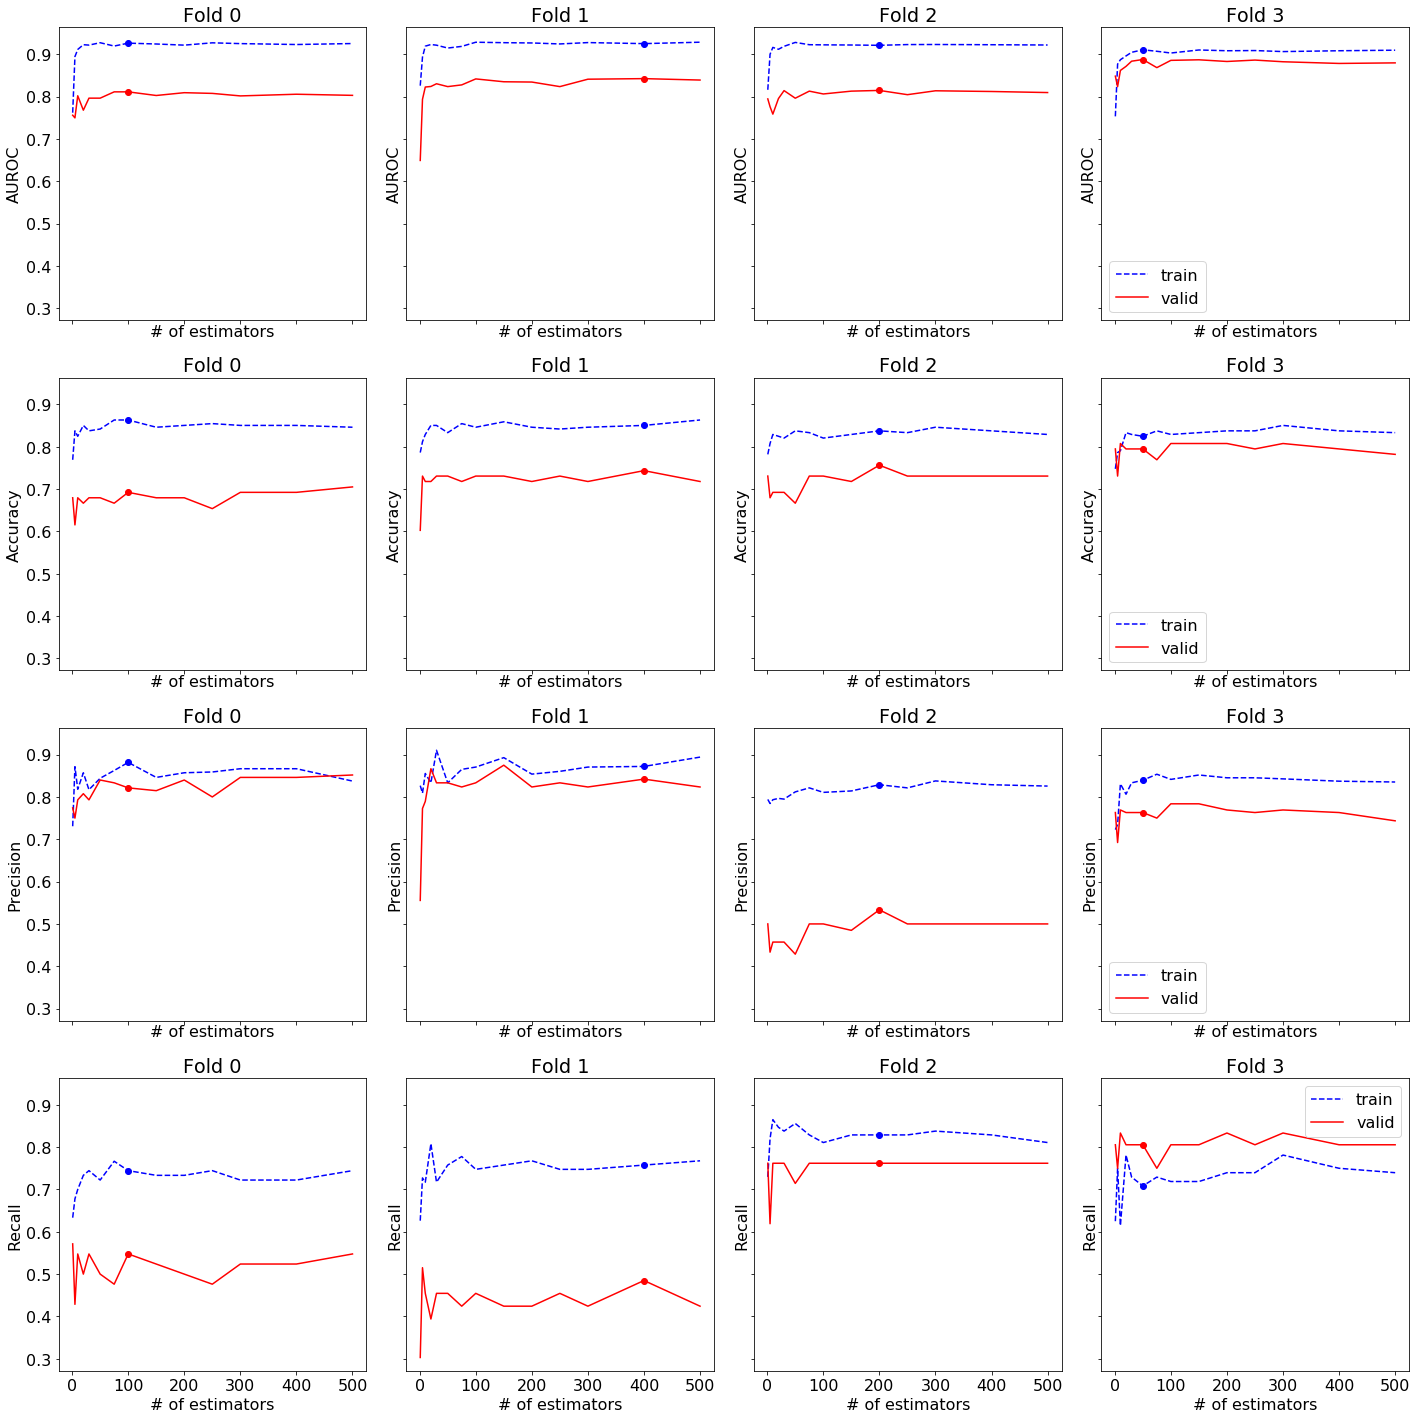

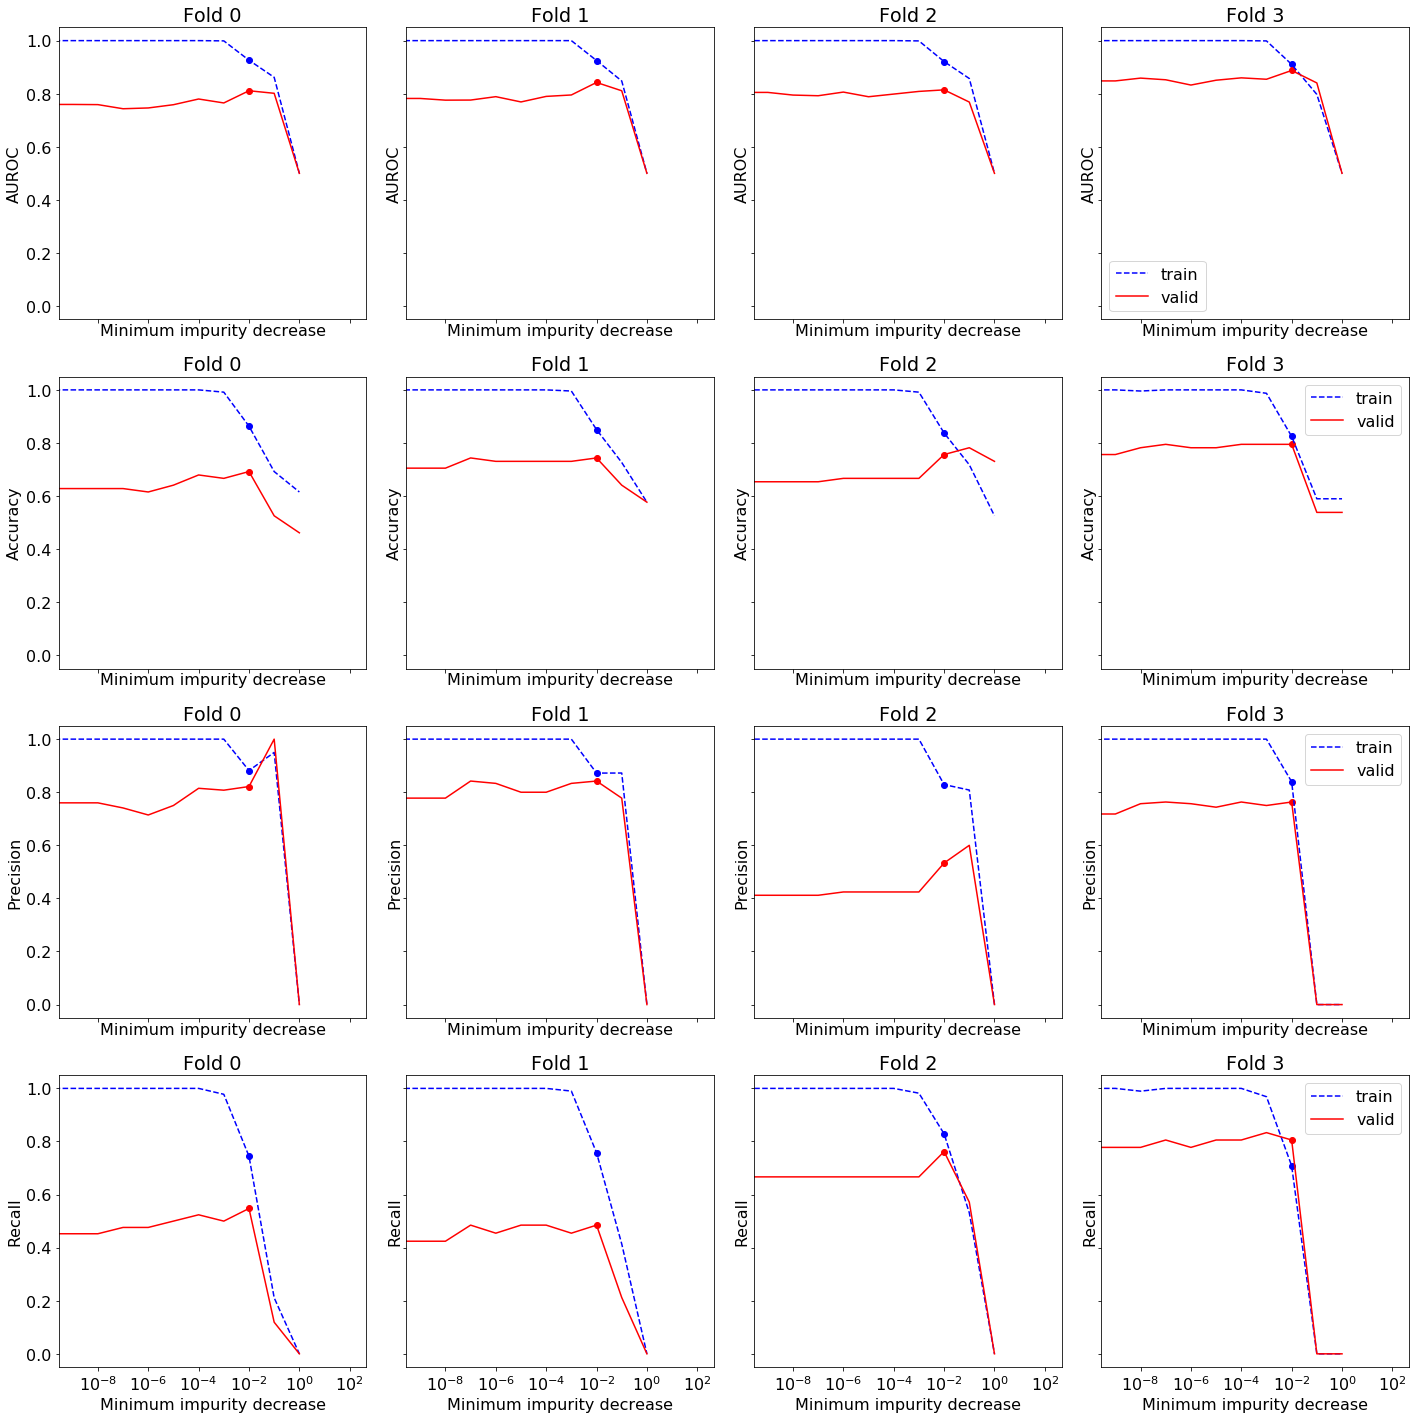

In [18]:
plt.rcParams.update({'font.size': 16})
fold_test_metrics_dict = {'auroc': [], 'acc': [], 'prec': [], 'rec': []}
fold_test_coefs = pd.DataFrame({'Feature': motor_bl_cov_set})
fold_vary_n_estimators_fig, fold_vary_n_estimators_ax = plt.subplots(nrows=4, ncols=4, figsize=(20,20), sharex=True, \
                                                                     sharey=True)
fold_vary_min_impurity_fig, fold_vary_min_impurity_ax \
    = plt.subplots(nrows=4, ncols=4, figsize=(20,20), sharex=True, sharey=True)
metric_list = ['auroc', 'acc', 'prec', 'rec']
metric_human_readable_list = ['AUROC', 'Accuracy', 'Precision', 'Recall']
fold_test_preds = pd.DataFrame({'PATNO': test_patnos_arr})
fold_test_probs = pd.DataFrame({'PATNO': test_patnos_arr})
for fold_idx in range(4):
    train_X = train_X_folds[fold_idx]
    train_Y = train_Y_folds[fold_idx]
    valid_X = valid_X_folds[fold_idx]
    valid_Y = valid_Y_folds[fold_idx]
    n_estimators_choices = [1, 5, 10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 400, 500]
    min_impurities = [0., 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.]
    best_valid_auroc = 0.
    best_valid_acc = 0.
    best_valid_prec = 0.
    best_valid_rec = 0.
    train_vary_n_estimators_metrics_dict = dict()
    train_vary_min_impurity_metrics_dict = dict()
    valid_vary_n_estimators_metrics_dict = dict()
    valid_vary_min_impurity_metrics_dict = dict()
    for min_impurity in min_impurities:
        train_vary_n_estimators_metrics_dict[min_impurity] = {'auroc': [], 'acc': [], 'prec': [], 'rec': []}
        valid_vary_n_estimators_metrics_dict[min_impurity] = {'auroc': [], 'acc': [], 'prec': [], 'rec': []}
    for n_estimators in n_estimators_choices:
        train_vary_min_impurity_metrics_dict[n_estimators] = {'auroc': [], 'acc': [], 'prec': [], 'rec': []}
        valid_vary_min_impurity_metrics_dict[n_estimators] = {'auroc': [], 'acc': [], 'prec': [], 'rec': []}
        for min_impurity in min_impurities:
            random_forest = RandomForestClassifier(n_estimators=n_estimators, min_impurity_decrease=min_impurity)
            random_forest.fit(train_X, train_Y)
            train_pred = random_forest.predict(train_X)
            train_prob = random_forest.predict_proba(train_X)[:,1]
            valid_pred = random_forest.predict(valid_X)
            valid_prob = random_forest.predict_proba(valid_X)[:,1]
            valid_auroc = roc_auc_score(valid_Y, valid_prob)
            valid_acc = accuracy_score(valid_Y, valid_pred)
            valid_prec = precision_score(valid_Y, valid_pred)
            valid_rec = recall_score(valid_Y, valid_pred)
            train_auroc = roc_auc_score(train_Y, train_prob)
            train_acc = accuracy_score(train_Y, train_pred)
            train_prec = precision_score(train_Y, train_pred)
            train_rec = recall_score(train_Y, train_pred)
            train_vary_n_estimators_metrics_dict[min_impurity]['auroc'].append(train_auroc)
            train_vary_n_estimators_metrics_dict[min_impurity]['acc'].append(train_acc)
            train_vary_n_estimators_metrics_dict[min_impurity]['prec'].append(train_prec)
            train_vary_n_estimators_metrics_dict[min_impurity]['rec'].append(train_rec)
            train_vary_min_impurity_metrics_dict[n_estimators]['auroc'].append(train_auroc)
            train_vary_min_impurity_metrics_dict[n_estimators]['acc'].append(train_acc)
            train_vary_min_impurity_metrics_dict[n_estimators]['prec'].append(train_prec)
            train_vary_min_impurity_metrics_dict[n_estimators]['rec'].append(train_rec)
            valid_vary_n_estimators_metrics_dict[min_impurity]['auroc'].append(valid_auroc)
            valid_vary_n_estimators_metrics_dict[min_impurity]['acc'].append(valid_acc)
            valid_vary_n_estimators_metrics_dict[min_impurity]['prec'].append(valid_prec)
            valid_vary_n_estimators_metrics_dict[min_impurity]['rec'].append(valid_rec)
            valid_vary_min_impurity_metrics_dict[n_estimators]['auroc'].append(valid_auroc)
            valid_vary_min_impurity_metrics_dict[n_estimators]['acc'].append(valid_acc)
            valid_vary_min_impurity_metrics_dict[n_estimators]['prec'].append(valid_prec)
            valid_vary_min_impurity_metrics_dict[n_estimators]['rec'].append(valid_rec)
            if valid_auroc > best_valid_auroc or (valid_auroc == best_valid_auroc and valid_acc > best_valid_acc) \
                or (valid_auroc == best_valid_auroc and valid_acc == best_valid_acc and valid_prec > best_valid_prec) \
                or (valid_auroc == best_valid_auroc and valid_acc == best_valid_acc and valid_prec == best_valid_prec \
                    and valid_rec > best_valid_rec):
                best_valid_auroc = valid_auroc
                best_valid_acc = valid_acc
                best_valid_prec = valid_prec
                best_valid_rec = valid_rec
                best_train_metrics_list = [train_auroc, train_acc, train_prec, train_rec]
                best_min_impurity = min_impurity
                best_n_estimators = n_estimators
                best_test_pred = random_forest.predict(test_X)
                best_test_prob = random_forest.predict_proba(test_X)[:,1]
                best_coefs = random_forest.feature_importances_.flatten()
    best_valid_metrics_list = [best_valid_auroc, best_valid_acc, best_valid_prec, best_valid_rec]
    for metric_idx in range(len(metric_list)):
        metric = metric_list[metric_idx]
        n_estim_ax = fold_vary_n_estimators_ax[metric_idx, fold_idx]
        n_estim_ax.plot(n_estimators_choices, train_vary_n_estimators_metrics_dict[best_min_impurity][metric], c='b', \
                        linestyle='--', label='train')
        n_estim_ax.scatter(best_n_estimators, best_train_metrics_list[metric_idx], c='b')
        n_estim_ax.plot(n_estimators_choices, valid_vary_n_estimators_metrics_dict[best_min_impurity][metric], c='r', \
                        label='valid')
        n_estim_ax.scatter(best_n_estimators, best_valid_metrics_list[metric_idx], c='r')
        n_estim_ax.set_xlabel('# of estimators')
        n_estim_ax.set_ylabel(metric_human_readable_list[metric_idx])
        n_estim_ax.set_title('Fold ' + str(fold_idx))
        min_impur_ax = fold_vary_min_impurity_ax[metric_idx, fold_idx]
        min_impur_ax.plot(min_impurities, train_vary_min_impurity_metrics_dict[best_n_estimators][metric], c='b', \
                          linestyle='--', label='train')
        min_impur_ax.scatter(best_min_impurity, best_train_metrics_list[metric_idx], c='b')
        min_impur_ax.plot(min_impurities, valid_vary_min_impurity_metrics_dict[best_n_estimators][metric], c='r', \
                          label='valid')
        min_impur_ax.scatter(best_min_impurity, best_valid_metrics_list[metric_idx], c='r')
        min_impur_ax.set_xlabel('Minimum impurity decrease')
        min_impur_ax.set_ylabel(metric_human_readable_list[metric_idx])
        min_impur_ax.set_title('Fold ' + str(fold_idx))
        min_impur_ax.set_xscale('log')
    fold_test_coefs['coef_fold' + str(fold_idx)] = best_coefs
    fold_test_metrics_dict['auroc'].append(roc_auc_score(test_Y, best_test_prob))
    fold_test_metrics_dict['acc'].append(accuracy_score(test_Y, best_test_pred))
    fold_test_metrics_dict['prec'].append(precision_score(test_Y, best_test_pred))
    fold_test_metrics_dict['rec'].append(recall_score(test_Y, best_test_pred))
    fold_test_preds['pred_fold' + str(fold_idx)] = best_test_pred
    fold_test_probs['prob_fold' + str(fold_idx)] = best_test_prob
for metric_idx in range(len(metric_list)):
    fold_vary_n_estimators_ax[metric_idx, 3].legend()
    fold_vary_min_impurity_ax[metric_idx, 3].legend()
fold_vary_n_estimators_fig.tight_layout()
fold_vary_n_estimators_fig.show()
fold_vary_min_impurity_fig.tight_layout()
fold_vary_min_impurity_fig.show()

In [44]:
print(fold_test_metrics_dict)

{'prec': [1.0, 0.6363636363636364, 0.5333333333333333, 0.6923076923076923], 'acc': [0.6607142857142857, 0.6964285714285714, 0.6607142857142857, 0.7321428571428571], 'auroc': [0.6763888888888889, 0.6388888888888888, 0.6340277777777777, 0.6513888888888888], 'rec': [0.05, 0.35, 0.4, 0.45]}


In [46]:
# Check David's claim that AUROC is only ranking
y_true = [0,0,0,1,1,1,1]
y_pred1 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
y_pred2 = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
y_pred3 = [0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.57]
y_pred4 = [0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97]
print(roc_auc_score(y_true, y_pred1))
print(roc_auc_score(y_true, y_pred2))
print(roc_auc_score(y_true, y_pred3))
print(roc_auc_score(y_true, y_pred4))

1.0
1.0
1.0
1.0


In [47]:
# Check David's claim that AUROC is only ranking
y_true = [0,1,0,1,1,0,1]
y_pred1 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
y_pred2 = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
y_pred3 = [0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.57]
y_pred4 = [0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97]
print(roc_auc_score(y_true, y_pred1))
print(roc_auc_score(y_true, y_pred2))
print(roc_auc_score(y_true, y_pred3))
print(roc_auc_score(y_true, y_pred4))

0.6666666666666667
0.6666666666666667
0.6666666666666667
0.6666666666666667


In [8]:
from scipy.stats import norm
def calc_sample_size(p_c, relative_risk_reduction, power):
    p_t = (1.-relative_risk_reduction)*p_c
    a = norm.ppf(0.975) # assume alpha = 0.05
    b = norm.ppf(power)
    return (a+b)**2*(p_c*(1.-p_c) + p_t*(1.-p_t))/((p_c-p_t)**2)

In [21]:
# Compute sample size reduction from pred
import math
inc_test_patnos = fold_test_preds.loc[fold_test_preds['pred_fold0']==1].PATNO.values
orig_test_patnos = fold_test_preds['PATNO'].values
inc_p_c = surv_df_filter2.loc[surv_df_filter2['PATNO'].isin(inc_test_patnos)]['Motor_E'].mean()
orig_p_c = surv_df_filter2.loc[surv_df_filter2['PATNO'].isin(orig_test_patnos)]['Motor_E'].mean()
inc_n = int(math.ceil(calc_sample_size(inc_p_c, .2, .8)))
orig_n = int(math.ceil(calc_sample_size(orig_p_c, .2, .8)))
inc_screen_n = int(math.ceil(inc_n*len(orig_test_patnos)/float(len(inc_test_patnos))))
print('{0:.2f}%'.format(inc_p_c*100.) + ' of ' + str(len(inc_test_patnos)) + ' predicted patients observed')
print('{0:.2f}%'.format(orig_p_c*100.) + ' of ' + str(len(orig_test_patnos)) + ' test patients observed')
print('Required sample size reduced from ' + str(orig_n) + ' to ' + str(inc_n))
print('Anticipate screening ' + str(inc_screen_n) + ' patients')

70.00% of 10 predicted patients observed
35.71% of 56 test patients observed
Required sample size reduced from 668 to 183
Anticipate screening 1025 patients


In [12]:
inc_test_patnos = fold_test_preds.loc[fold_test_preds['pred_fold1']==1].PATNO.values
orig_test_patnos = fold_test_preds['PATNO'].values
print(len(inc_test_patnos))
inc_p_c = surv_df_filter2.loc[surv_df_filter2['PATNO'].isin(inc_test_patnos)]['Motor_E'].mean()
orig_p_c = surv_df_filter2.loc[surv_df_filter2['PATNO'].isin(orig_test_patnos)]['Motor_E'].mean()
print(calc_sample_size(inc_p_c, .2, .8))
print(calc_sample_size(orig_p_c, .2, .8))

11
233.22385496351606
667.1547774196731


In [13]:
inc_test_patnos = fold_test_preds.loc[fold_test_preds['pred_fold2']==1].PATNO.values
orig_test_patnos = fold_test_preds['PATNO'].values
print(len(inc_test_patnos))
inc_p_c = surv_df_filter2.loc[surv_df_filter2['PATNO'].isin(inc_test_patnos)]['Motor_E'].mean()
orig_p_c = surv_df_filter2.loc[surv_df_filter2['PATNO'].isin(orig_test_patnos)]['Motor_E'].mean()
print(calc_sample_size(inc_p_c, .2, .8))
print(calc_sample_size(orig_p_c, .2, .8))

19
288.267946607003
667.1547774196731


In [14]:
inc_test_patnos = fold_test_preds.loc[fold_test_preds['pred_fold3']==1].PATNO.values
orig_test_patnos = fold_test_preds['PATNO'].values
print(len(inc_test_patnos))
inc_p_c = surv_df_filter2.loc[surv_df_filter2['PATNO'].isin(inc_test_patnos)]['Motor_E'].mean()
orig_p_c = surv_df_filter2.loc[surv_df_filter2['PATNO'].isin(orig_test_patnos)]['Motor_E'].mean()
print(calc_sample_size(inc_p_c, .2, .8))
print(calc_sample_size(orig_p_c, .2, .8))

15
266.861910967869
667.1547774196731
